In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from tqdm import tqdm

In [3]:
def create_discriminator():
    d_input = Input(shape=(2,))
    d = Dense(30, activation='relu')(d_input)
    d = Dense(20, activation='relu')(d)
    d = Dense(10, activation='relu')(d)
    d_output = Dense(1, activation='sigmoid')(d)

    discriminator = Model(d_input, d_output)

    discriminator.compile(loss='binary_crossentropy', 
                          optimizer='adam', 
                          metrics=['acc'])
    
    return discriminator

In [4]:
d_test = create_discriminator()
d_test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


In [5]:
def create_generator():
    g_input = Input(shape=(10,))
    g = Dense(16, activation='relu')(g_input)
    g = Dense(8, activation='relu')(g)
    g = Dense(4, activation='relu')(g)
    g_output = Dense(2, activation='linear', 
                     kernel_initializer='he_uniform')(g)
    
    generator = Model(g_input, g_output)
    
    return generator

In [6]:
g_test = create_generator()
g_test.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
Total params: 358
Trainable params: 358
Non-trainable params: 0
_________________________________________________________________


In [7]:
def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(10,))
    gan = generator(gan_input)
    gan_output = discriminator(gan)
    
    gan = Model(gan_input, gan_output)

    gan.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['acc'])
    
    return gan

In [8]:
gan_test = create_gan(g_test, d_test)
gan_test.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
model_1 (Functional)         (None, 2)                 358       
_________________________________________________________________
model (Functional)           (None, 1)                 931       
Total params: 1,289
Trainable params: 358
Non-trainable params: 931
_________________________________________________________________


In [11]:
def create_real_samples(n_data):
    x_real = np.random.normal(0, 3, n_data)
    y_real = np.sin(x_real)
    
    x_real = x_real.reshape(x_real.shape[0], 1)
    y_real = y_real.reshape(y_real.shape[0], 1)
    
    features_real = np.hstack((x_real, y_real))
    labels_real = np.array([1] * n_data)
    
    return features_real, labels_real

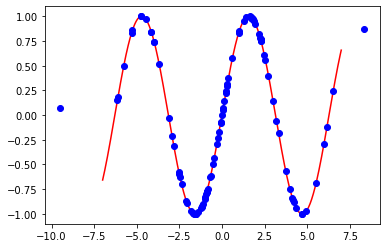

In [12]:
x_line = np.linspace(-7, 7, 1000)
y_line = np.sin(x_line)
plt.plot(x_line, y_line, c='r', zorder=0)

f_real_test, l_real_test = create_real_samples(100)
plt.scatter(f_real_test[:,0], f_real_test[:,1], c='b', zorder=1)

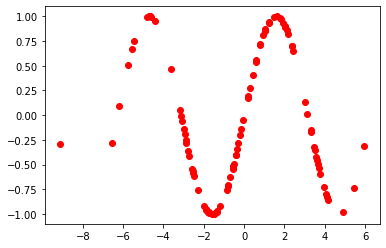

In [13]:
f_real_test, l_real_test = create_real_samples(100)
plt.scatter(f_real_test[:,0], f_real_test[:,1], c='r')

In [14]:
def create_fake_samples(generator, n_data):
    latent_points = np.random.normal(0, 3, (n_data, 10))
    features_fake = generator.predict(latent_points)
    
    labels_fake = np.array([0] * n_data)
    return features_fake, labels_fake

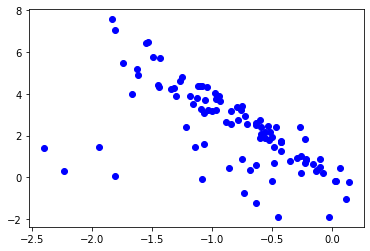

In [15]:
f_fake_test, l_fake_test = create_fake_samples(g_test, 100)
plt.scatter(f_fake_test[:,0], f_fake_test[:,1], c='b')

In [16]:
def visualize(generator, n_data):
    feats_real, labels_real = create_real_samples(n_data)
    feats_fake, labels_fake = create_fake_samples(generator, 
                                                  n_data)
    
    plt.scatter(feats_real[:,0], feats_real[:,1], c='r')
    plt.scatter(feats_fake[:,0], feats_fake[:,1], c='b')
    plt.show()

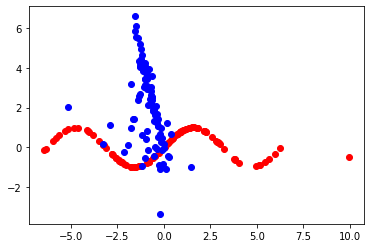

In [17]:
visualize(g_test, 100)

In [18]:
def train(generator, discriminator, gan, epochs, batch_size):
    for i in tqdm(range(epochs)):
        feats_real, labels_real = create_real_samples(batch_size)
        feats_fake, labels_fake = create_fake_samples(generator, 
                                                      batch_size)
        
        discriminator.train_on_batch(feats_real, labels_real)
        discriminator.train_on_batch(feats_fake, labels_fake)
        
        latent_points = np.random.normal(0, 3, (batch_size, 10))
        labels_gan = np.array([1] * batch_size)
        
        gan.train_on_batch(latent_points, labels_gan)
        
        if i == 0:
            visualize(generator, batch_size)
        elif i%1000 == 0:
            visualize(generator, batch_size)

  0%|          | 0/10000 [00:00<?, ?it/s]

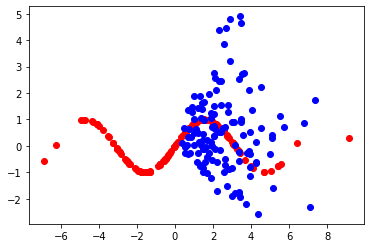

 10%|▉         | 999/10000 [00:57<08:12, 18.28it/s]

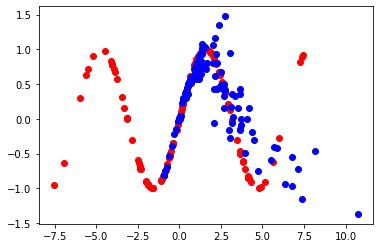

 20%|█▉        | 1999/10000 [01:55<07:45, 17.19it/s]

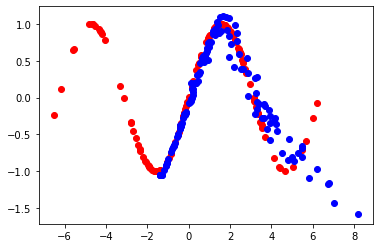

 30%|██▉       | 2999/10000 [02:51<06:28, 18.01it/s]

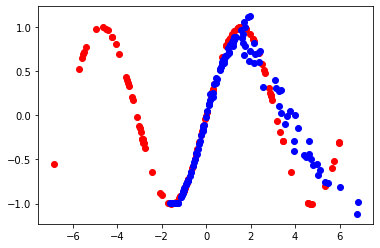

 40%|███▉      | 3999/10000 [03:47<05:34, 17.94it/s]

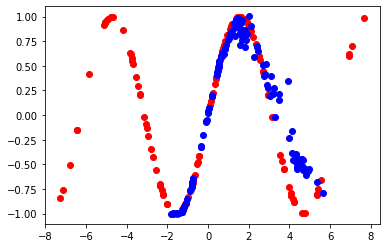

 50%|█████     | 5000/10000 [04:43<04:56, 16.85it/s]

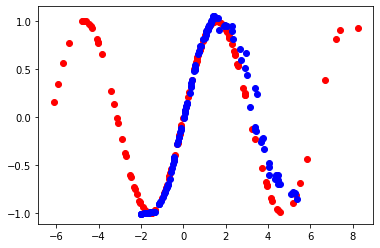

 60%|██████    | 6000/10000 [05:41<03:42, 17.97it/s]

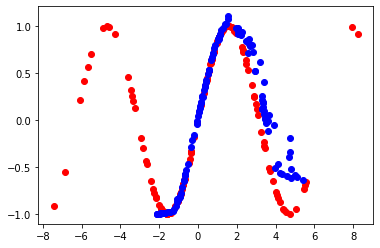

 70%|███████   | 7000/10000 [06:37<02:47, 17.91it/s]

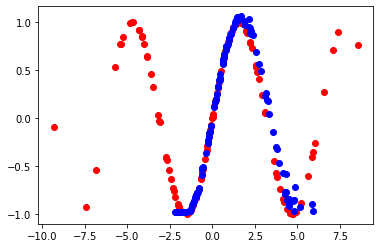

 80%|████████  | 8000/10000 [07:34<01:51, 18.00it/s]

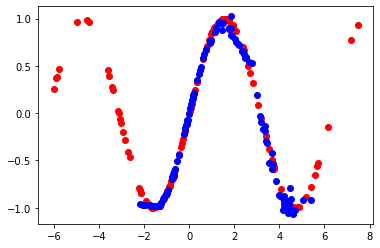

 90%|█████████ | 9000/10000 [08:30<00:55, 17.97it/s]

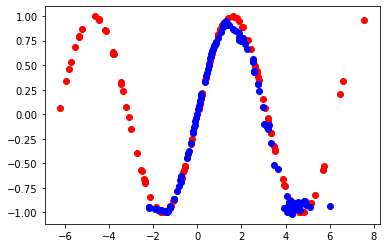

100%|██████████| 10000/10000 [09:25<00:00, 17.67it/s]


In [19]:
EPOCHS = 10000
BATCH_SIZE = 128

discriminator = create_discriminator()
generator = create_generator()
gan = create_gan(generator, discriminator)

train(generator, discriminator, gan, 
      EPOCHS, BATCH_SIZE)

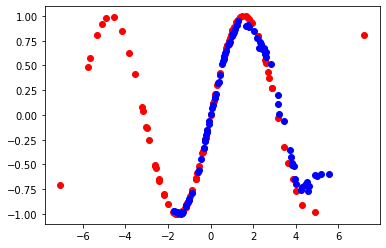

In [20]:
visualize(generator, 100)